# Notebook Instructions

1. If you are new to Jupyter notebooks, please go through this introductory manual <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank">here</a>.
1. Any changes made in this notebook would be lost after you close the browser window. **You can download the notebook to save your work on your PC.**
1. Before running this notebook on your local PC:<br>
i.  You need to set up a Python environment and the relevant packages on your local PC. To do so, go through the section on "**Run Codes Locally on Your Machine**" in the course.<br>
ii. You need to **download the zip file available in the last unit** of this course. The zip file contains the data files and/or python modules that might be required to run this notebook.

# Implementing TIPP with Volatility Targeting

We will now include volatility targeting in TIPP. The multiplier will become a function of the current volatility and the target volatility. We will calculate the leverage based on the updated multiplier value. It will leverage the portfolio based on the fluctuations in the underlying.

In this notebook, you will perform the following steps:

1. [Read the Data](#read)
2. [Volatility Calculation](#vol)
3. [Leverage Calculation](#lev_cal)
3. [Setting Portfolio Value, Multiplier Value, Floor Value](#portfolio_val)
4. [Update the TIPP Code for Adjusting Multiplier w.r.t. Volatility](#strategy_logic)
5. [Portion of Capital](#portion)
6. [Leverage Ratio](#leverage)

## Import Libraries

In [3]:
# Data manipulation
import pandas as pd
import numpy as np

# Quantra function to analyse the performance
import sys
sys.path.append("..")
from data_modules.position_sizing_quantra import performance_analysis, plot_leverage, plot_portion_of_capital

# Import matplotlib and set the style
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

# Ignore warnings
import warnings 
warnings.filterwarnings('ignore')

<a id='read'></a>
## Read the Data

The SPY ETF price is read from `SPY_data_15_59.csv`. The index reversal strategy's trading signal, returns and portfolio value are read from a file named `strategy_data.csv`.

In [5]:
# Read the price data for one minute before the close
spy_price = pd.read_csv(
    '../data_modules/SPY_data_15_59.csv', index_col=0, parse_dates=True)

# Set the date as the index for the price data
spy_price.index = pd.to_datetime(spy_price.index.date)

# Consider the data starting from 1st January 2005
spy_price = spy_price.loc['2005-01-01':]

# Read the signal and returns of the index reversal strategy
strategy_df = pd.read_csv('../data_modules/strategy_data.csv',
                          index_col=0, parse_dates=True)

strategy_df.head()

,signal,returns,cumulative_returns
2005-01-03,0,-0.000000,1.000000
2005-01-04,1,-0.000000,1.000000
2005-01-05,1,-0.003537,0.996463
2005-01-06,0,0.003296,0.999747
2005-01-07,0,-0.000000,0.999747


<a id='vol'></a>
## Volatility Calculation

The volatility of the asset returns is calculated.

In [7]:
# Define the target volatility
volatility_target = 0.01

# Calculate the asset returns
spy_price['returns'] = spy_price['Close'].pct_change()

# Calculate the volatility of the asset returns
window = 20
spy_price['volatility'] = spy_price['returns'].rolling(window).std()

# Drop the rows with missing values
spy_price.dropna(inplace=True)

spy_price.head()

,Open,High,Low,Close,Volume,returns,volatility
2005-02-01,118.93,118.96,118.90,118.91,203500.0,0.007114,0.006419
2005-02-02,119.37,119.39,119.31,119.35,298500.0,0.003700,0.005975
2005-02-03,119.03,119.07,119.03,119.05,278900.0,-0.002514,0.005945
2005-02-04,120.34,120.35,120.31,120.31,230800.0,0.010584,0.006347
2005-02-07,120.19,120.25,120.16,120.23,186200.0,-0.000665,0.006338


<a id='lev_cal'></a>
## Leverage Calculation
The leverage is calculated using the target volatility and the asset returns volatility.

In [9]:
# Calculate the leverage based on target volatility
spy_price['leverage'] = volatility_target / spy_price['volatility'].shift(1)

# Define the maximum cap for the leverage
leverage_cap = 2

# Cap the leverage to the maximum value
spy_price['leverage'] = np.where(
    spy_price['leverage'] > leverage_cap, leverage_cap, spy_price['leverage'])

spy_price.dropna(inplace=True)
spy_price.head()

,Open,High,Low,Close,Volume,returns,volatility,leverage
2005-02-02,119.37,119.39,119.31,119.35,298500.0,0.003700,0.005975,1.557964
2005-02-03,119.03,119.07,119.03,119.05,278900.0,-0.002514,0.005945,1.673582
2005-02-04,120.34,120.35,120.31,120.31,230800.0,0.010584,0.006347,1.682040
2005-02-07,120.19,120.25,120.16,120.23,186200.0,-0.000665,0.006338,1.575631
2005-02-08,120.39,120.39,120.34,120.34,126300.0,0.000915,0.006312,1.577691


We drop `window + 1` rows to adjust for dropped rows from calculating volatility and leverage both

In [11]:
# Updating strategy_df  dataframe by dropping the first `window + 1` rows
strategy_df = strategy_df.iloc[window + 1:]

strategy_df.head()

,signal,returns,cumulative_returns
2005-02-02,0,0.0,1.004441
2005-02-03,0,-0.0,1.004441
2005-02-04,0,0.0,1.004441
2005-02-07,0,-0.0,1.004441
2005-02-08,0,0.0,1.004441


<a id='portfolio_val'></a>
## Setting Portfolio Value, Multiplier Value, Floor Value
1. We will define the initial portfolio value as $$ \text{Initial portfolio value = 10000}$$
2. We will define the multiplier $$\text{Multiplier = 4}$$ Multiplier can be defined as a function of past drawdowns of the index returns. So, if index has shown a drawdown of 25%, we use $$Multiplier = \frac{1}{Drawdown} = 4$$
3. We set a floor percentage level, $$\text{Floor percent = 0.60}$$

In [13]:
# Setting initial portfolio value
initial_portfolio_value = 10000

# Setting multiplier value
m = 4

# Setting floor falue
floor_percent = 0.60

print("Initial portfolio value: ", initial_portfolio_value)
print("Multiplier value: ", m)
print("Floor percent: ", floor_percent)

Initial portfolio value:  10000
Multiplier value:  4
Floor percent:  0.6


<a id='strategy_logic'></a>
## Update the TIPP Code for Adjusting Multiplier w.r.t. Volatility

The following steps are used for the TIPP Logic:
1. Initial steps from CPPI implementation of defining the cushion percentage, calculating initial cushion value, floor value and the initial account value remain the same.
2. Adjust the multiplier with the leverage calculated above as <span style="color:red">$$\text{New multiplier value = Multiplier * Leverage}$$</span>
3. The rest of the process is the same as in TIPP.

In [15]:
def run_tipp_vol(risky_r, m, initial_capital, floor_percent, leverage_df, signals):
    # Set up TIPP parameters
    cushion_percentage = 1 - floor_percent

    # Absolute values
    floor = floor_percent * initial_capital
    cushion = cushion_percentage * initial_capital

    # Create DFs for intermediate values
    account_history = pd.DataFrame([np.nan for _ in range(
        len(risky_r.index))], index=risky_r.index, columns=['account_history'])
    leverage_history = pd.DataFrame([np.nan for _ in range(
        len(risky_r.index))], index=risky_r.index, columns=['leverage_history'])
    capital_used = pd.DataFrame([np.nan for _ in range(
        len(risky_r.index))], index=risky_r.index, columns=['capital_used'])
    multiplier = pd.DataFrame([np.nan for _ in range(
        len(risky_r.index))], index=risky_r.index, columns=['multiplicator'])

    # Intialise variables
    account_value = initial_capital
    max_account_value = initial_capital
    cap_used = 0

    # Run TIPP
    for row in range(len(risky_r)):
        # Adjust the multiplier w.r.t. to the leverage based on volatility
        if row == 0:
            adj_multiplier = 0  
        else:
            adj_multiplier = m * leverage_df.iloc[row - 1]
        multiplier["multiplicator"].iloc[row] = adj_multiplier

        # The risky asset returns will be multiplied by `m`
        levered_return = adj_multiplier * risky_r.iloc[row]

        # Update account value and append to DF
        account_value = floor + (cushion * (1 + levered_return))

        # Check if account_value exceeds max_account_value
        if (account_value > max_account_value):
            # If current account value > max account value, recalculate floor
            floor = floor_percent * account_value

            # Update max_account_value
            max_account_value = account_value
        account_history["account_history"].iloc[row] = account_value

        # Recalculate cushion
        cushion = account_value - floor

        # Update leverage and append to DF
        leverage = adj_multiplier * (cushion / account_value)
        leverage_history["leverage_history"].iloc[row] = leverage

        # Calculate capital used and append to DF
        cap_used = leverage * account_value
        capital_used["capital_used"].iloc[row] = cap_used

    # Update leverage and capital based on signals only for trading days
    leverage_history["leverage_history"] = leverage_history["leverage_history"] * \
        signals
    capital_used["capital_used"] = capital_used["capital_used"] * \
        signals

    return {
        'account_history': account_history,
        'leverage_history': leverage_history,
        'capital_used': capital_used,
        'multiplier': multiplier
    }

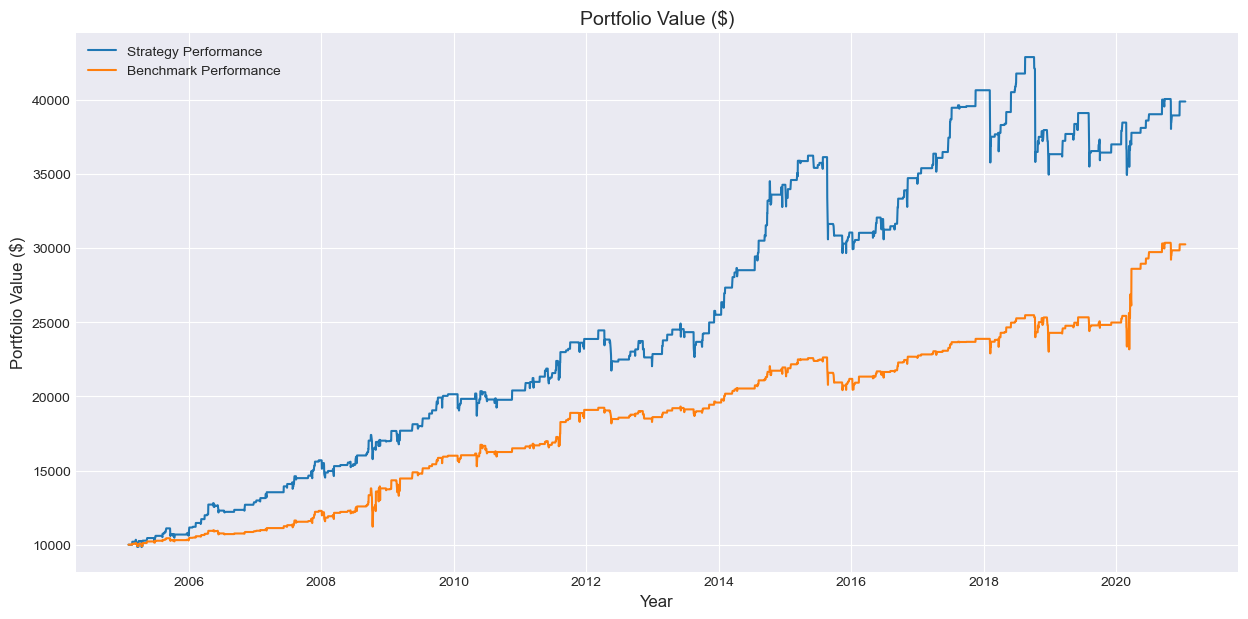

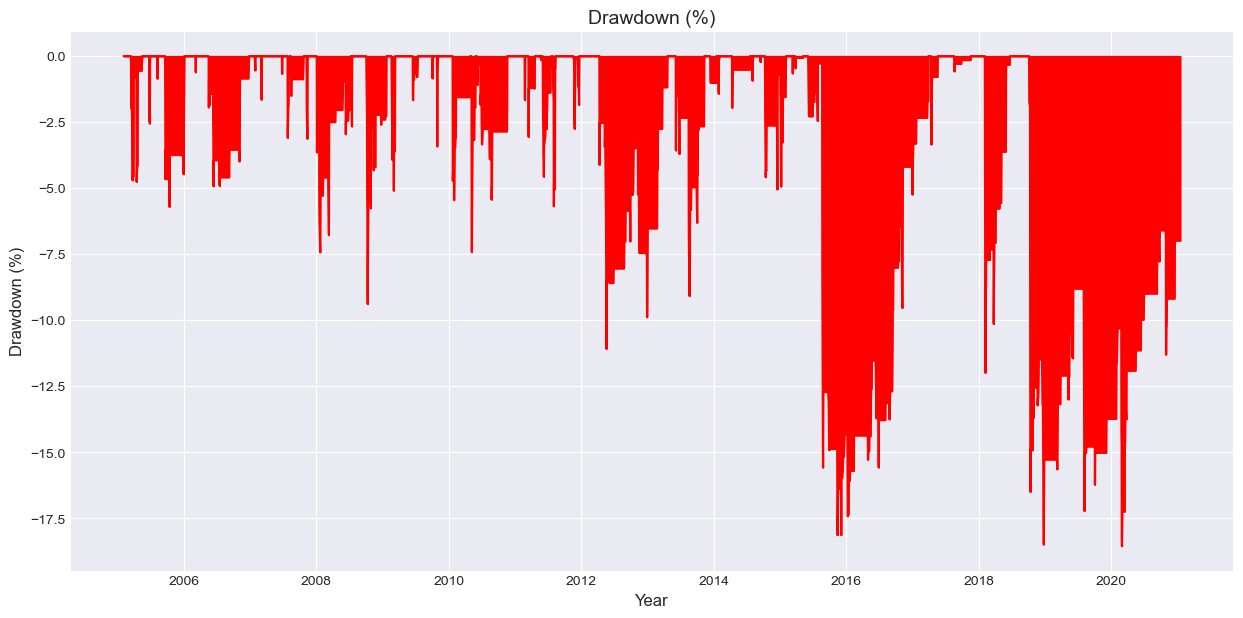

Total returns: 299.01%
Annualised returns (CAGR): 9.08%
Maximum drawdown (MDD): -18.55%
Return-to-MDD ratio: 0.49


In [16]:
# Run strategy with TIPP with volatility targeting
strategy = run_tipp_vol(
    strategy_df['returns'], m, initial_portfolio_value, floor_percent, spy_price['leverage'], strategy_df['signal'])

# TIPP with volatility targeting. strategy returns
strategy_with_tipp_vol = strategy['account_history']['account_history']

# Calculate benchmark returns (strategy without `TIPP with volatility targeting`)
benchmark_returns = initial_portfolio_value * \
    (1 + strategy_df['returns']).cumprod()

# Plot performance analysis
performance_analysis(strategy_with_tipp_vol, benchmark_returns)

If you compare the results to TIPP with similar parameters as above, the Return-to-MDD ratio has improved significantly from 0.39 to 0.55.

<a id='portion'></a>
## Portion of Capital
The plot shows the total wealth used in each trade which was calculated in `run_tipp_vol`.

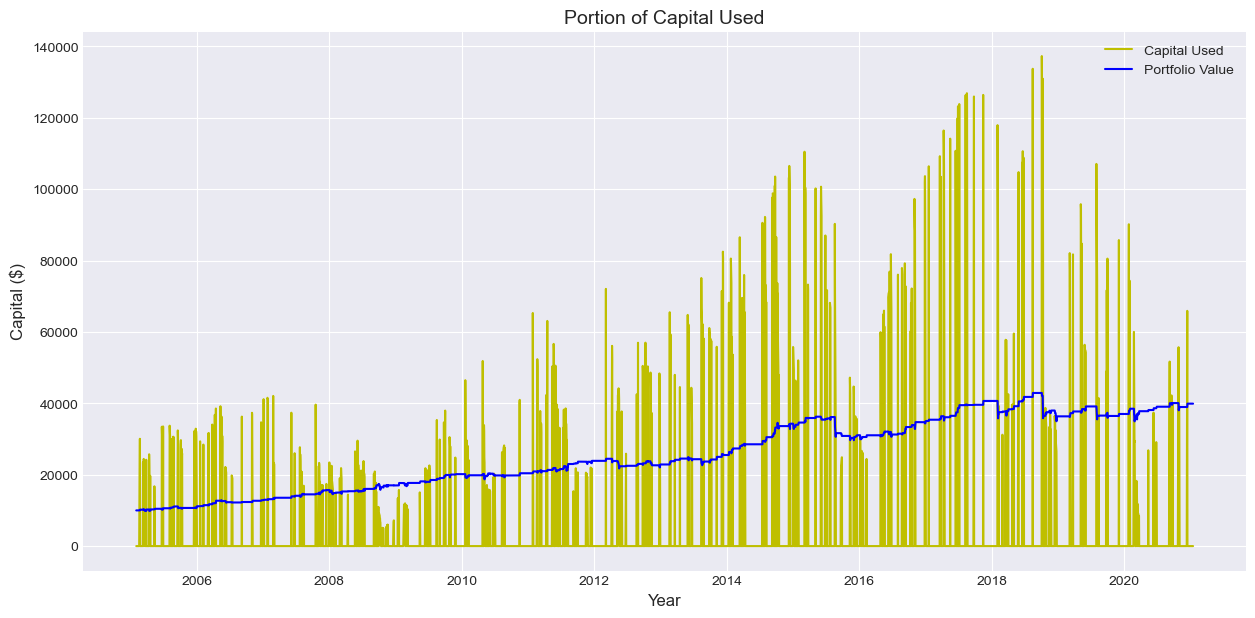

In [19]:
plot_portion_of_capital(strategy['capital_used'], strategy['account_history'])

In [20]:
# Plotting Volatility

# Set figure size
plt.figure(figsize=(15, 7))

# Plot volatility
plt.plot(spy_price['volatility'], color='red')

# Set labels
plt.title("Volatility", fontsize=14)
plt.xlabel("Year", fontsize=12);

From the above two graphs, we can see that as the volatility spikes the capital used decreases significantly. Therefore, we use more capital when the underlying asset is relatively calm, and less capital when the underlying asset fluctuates a lot. This hedges us from wild movements.

<a id='leverage'></a>
## Leverage Plot
The leverage plot shows the amount used over and above the actual account value. For simplicity, we have not considered the cost of leverage in the strategy calculations.

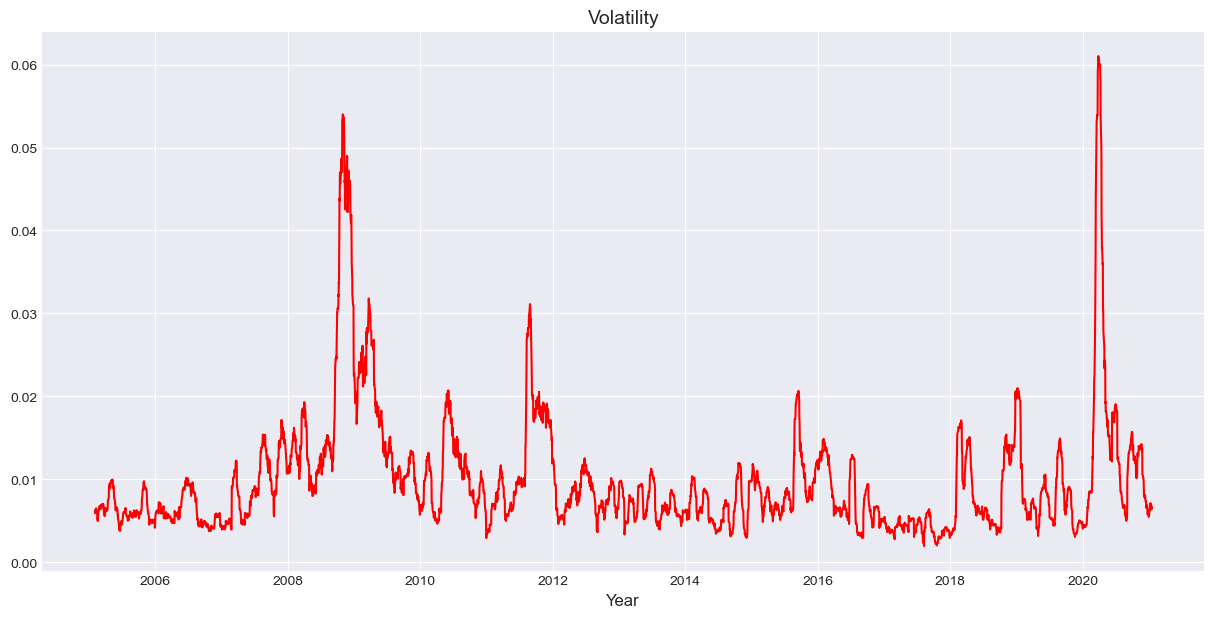

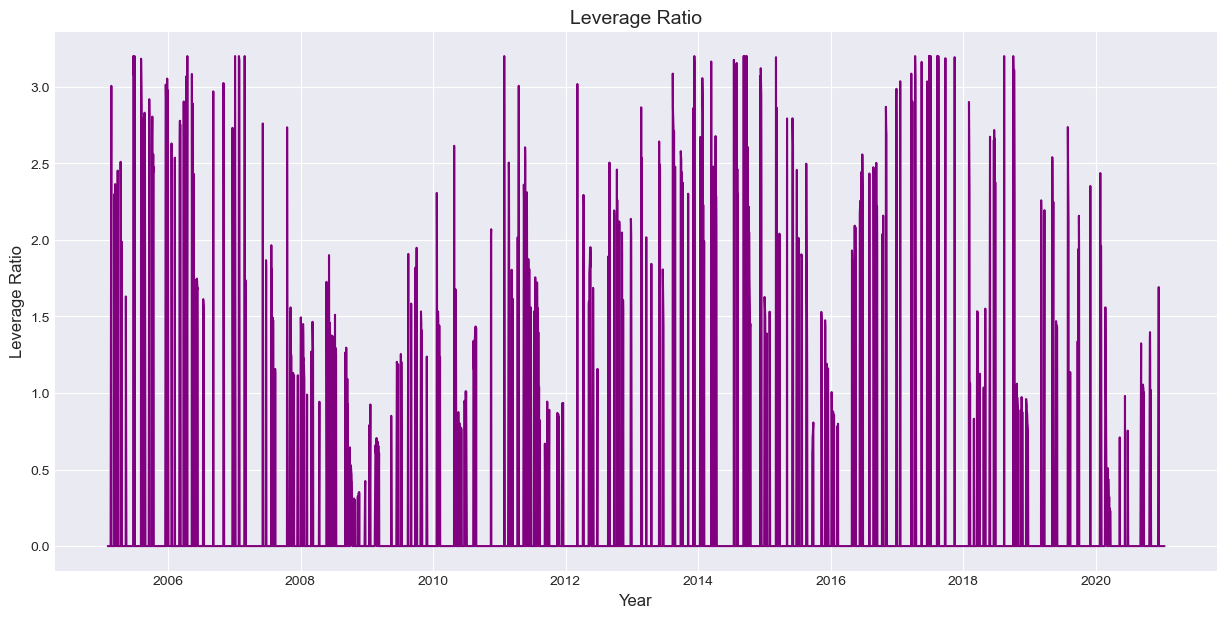

In [23]:
plot_leverage(strategy['leverage_history'])

## Tweak the Code
You can tweak the code in the following ways:

1. Use different multiplier values, and see how the strategy is affected.
2. Try out a different cap for the volatility with a new volatility target and see how the strategy reacts.
3. Change the trading strategy as you wish!